In [8]:
import git
import itertools
import tqdm
import pathlib
import simdjson
from collections import defaultdict
import pandas as pd

In [2]:
p = pathlib.Path('./conda-forge-status-monitor', odbt=git.GitCmdObjectDB)
if p.exists():
    repo = git.Repo(p)
else:
    repo = git.Repo.clone_from("https://github.com/conda-forge/conda-forge-status-monitor", 'conda-forge-status-monitor')

In [3]:
path = "data/latest.json"

In [4]:
num_commits = int(repo.git.rev_list('--count', 'HEAD'))

In [5]:
data_rates = defaultdict(dict)

In [6]:
pbartraverse = tqdm.tqdm(desc="git rev list", total=num_commits)
def commits():
    for commit in repo.iter_commits(paths=path):
        pbartraverse.update()
        yield commit
    pbartraverse.close()

all_commits = list(commits())
pbar = tqdm.tqdm(desc="json load", total=num_commits)

# The order in which we traverse commits is important, oldest first
# The most recent timestamp in each of the latest files is generally incomplete,
# so we need to ensure that the timestamps from the most recent files override older ones.
for commit in reversed(all_commits):
    pbar.update()
    data = (commit.tree / path).data_stream.read()
    slug = simdjson.loads(data)
    for provider, provider_data in slug.items():
        rates = provider_data.get('rates', {})
        data_rates[provider].update(rates)

json load: 100%|███████████████████████████████████████████████████████████████▉| 68905/68945 [00:48<00:00, 1470.96it/s]

In [9]:
df = pd.DataFrame(data_rates)

In [10]:
df.index = pd.to_datetime(df.index)

In [11]:
df.sort_index()

,azure-pipelines,travis-ci,github-actions,appveyor,circleci,drone
2021-03-16 09:40:00-04:00,4,0,4,0,0,1
2021-03-16 09:45:00-04:00,10,0,13,0,0,1
2021-03-16 09:50:00-04:00,31,1,20,0,0,0
2021-03-16 09:55:00-04:00,17,0,20,0,0,0
2021-03-16 10:00:00-04:00,11,1,7,0,0,0
...,...,...,...,...,...,...
2021-10-27 17:35:00-04:00,14,0,0,0,0,1
2021-10-27 17:40:00-04:00,27,0,12,0,0,0
2021-10-27 17:45:00-04:00,15,0,13,0,0,0
2021-10-27 17:50:00-04:00,9,0,6,0,0,0


In [12]:
sums = dict(df.sum())


json load: 100%|███████████████████████████████████████████████████████████████▉| 68923/68945 [00:58<00:00, 1470.96it/s]

In [13]:
def key(idx):
    return [-sums[c] for c in idx]

In [14]:
df = df.sort_index(axis=1, key=key)

In [15]:
%matplotlib inline

In [16]:
df_daily = df.resample('D').sum()

<AxesSubplot:ylabel='number of builds'>

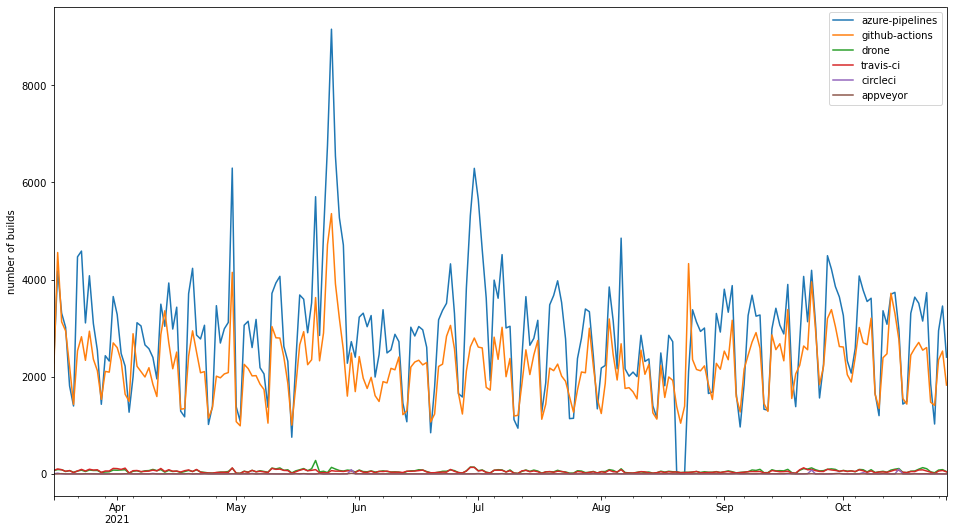

In [17]:
df_daily.plot(figsize=(16, 9), ylabel='number of builds')

In [18]:
df_daily_rolling = df_daily.rolling(7).mean()

<AxesSubplot:title={'center':'7 day moving avg'}, ylabel='number of builds'>

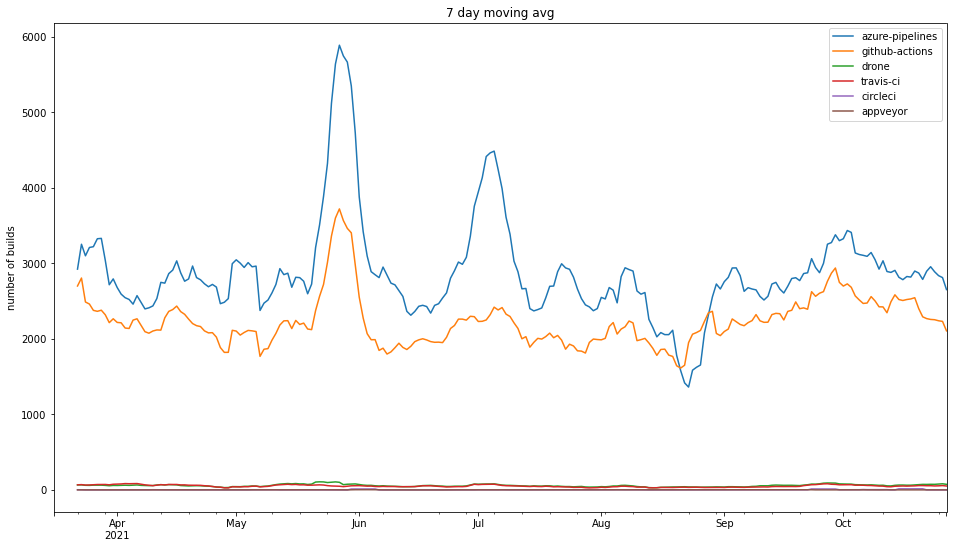

In [19]:
df_daily_rolling.plot(figsize=(16, 9), title='7 day moving avg', ylabel='number of builds')